<a href="https://colab.research.google.com/github/rishabhshah13/Adversarial_Patch_XAI590/blob/main/Assignment%208/Assignment%208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 8

In [1]:
!pip install transformers captum matplotlib

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from captum.attr import IntegratedGradients, Saliency
import matplotlib.pyplot as plt
import numpy as np


# Load model and tokenizer
model_name = "gpt2-xl"
# model_name = "unsloth/Llama-3.2-1B"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()  # Set the model to evaluation mode

prompt = "What do you do when you're tired? Sleep"   ## low-key want the model to return 'coffee' as answer


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


This notebook demonstrates how to apply XAI techniques such as perturbations, saliency scores, and counterfactuals to analyze key components of a prompt (symbols, patterns, and text) in an LLM like GPT-2.


# 1. Perturbation-Based Analysis

Removing or replacing key words and observe how this affects the model's output. This helps us identify which parts of the prompt are critical for generating accurate responses.

## Explanation
- Original Prompt: We start with a factual statement: "What do you do when you're tired? Sleep"
- Perturbation: Removed the word "Sleep" from the original prompt to see how it affects the model's response.
- Goal: This method helps identify whether specific words (in this case, "Sleep") are crucial for generating accurate responses.

In [3]:
# Install necessary libraries
def generate_text(prompt):
    """
    Generates text using the pre-trained LLM.

    Args:
        prompt (str): The input text prompt.

    Returns:
        str: The generated text output from the model.
    """
    # Tokenize the input prompt and generate output
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=30)

    # Decode the generated tokens into readable text
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def perturb_prompt(prompt, word_to_remove):
    """
    Perturbs the input prompt by removing a specific word.

    Args:
        prompt (str): The original input text prompt.
        word_to_remove (str): The word to remove from the prompt.

    Returns:
        str: The perturbed version of the prompt.
    """
    # Remove the specified word from the prompt
    perturbed_prompt = prompt.replace(word_to_remove, " ")
    return perturbed_prompt

# Example Prompt

# Perturbation-based analysis: Remove 'Paris'
perturbed_prompt = perturb_prompt(prompt, "Sleep")

# Generate and display outputs for both original and perturbed prompts
print(f"Original Output: {generate_text(prompt)}")
print(f"Perturbed Output: {generate_text(perturbed_prompt)}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Original Output: What do you do when you're tired? Sleep.

I'm not sure if I'm the only one who's ever had to deal with
Perturbed Output: What do you do when you're tired?                     


# 2. Saliency-Based Analysis

Computing saliency scores using Integrated Gradients to determine which tokens in the input prompt are most important for generating the output. Saliency maps highlight token importance by attributing higher scores to more influential words.

## Explanation

- Saliency Scores: Used Integrated Gradients from Captum to compute how much each token contributes to generating the output. Tokens with higher saliency scores are more important for prediction.
- Visualization: A bar chart shows how much each token in "What do you do when you're tired? Sleep" contributes to generating an accurate response.

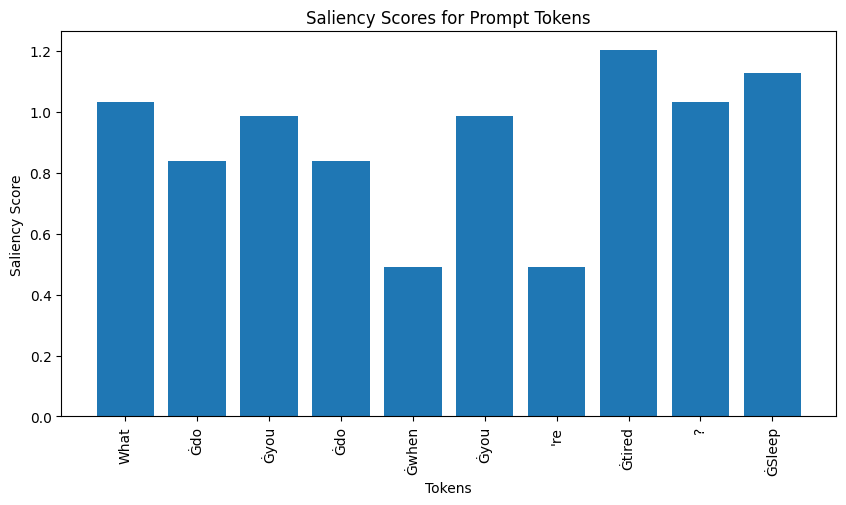

In [4]:
# Function to get token-level saliency scores
def get_saliency_scores(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]

    # Forward pass through the model
    outputs = model(input_ids)
    logits = outputs.logits

    # Get the predicted token (we'll focus on the last token)
    predicted_token_id = torch.argmax(logits[:, -1, :], dim=-1)

    # Backpropagate to get gradients w.r.t. input tokens
    loss = logits[:, -1, predicted_token_id].sum()
    loss.backward()

    # Get gradients for input embeddings
    gradients = model.transformer.wte.weight.grad[input_ids].squeeze(0)

    # Calculate saliency scores as L2 norm of gradients for each token
    saliency_scores = torch.norm(gradients, dim=-1).detach().numpy()

    return saliency_scores, tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

# Function to plot saliency scores
def plot_saliency(prompt):
    saliency_scores, tokens = get_saliency_scores(prompt)

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(tokens)), saliency_scores)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title("Saliency Scores for Prompt Tokens")
    plt.xlabel("Tokens")
    plt.ylabel("Saliency Score")
    plt.show()


# Plot saliency scores for the example prompt
plot_saliency(prompt)

# 3. Counterfactual Explanation
Modifying part of the input (e.g., changing "Sleep" to "Coffee") and observe how this change affects the model’s response. Counterfactuals help us understand how small changes in input can lead to different outputs.

# Explanation
- Original Prompt: "What do you do when you're tired? Sleep" generates an expected response based on factual knowledge.
- Counterfactual Prompt: By changing "Sleep" to "Coffee", the generated output changes. This technique helps us understand how sensitive LLMs are to small changes in input.

In [ ]:
# Counterfactual Prompt: Change 'Sleep' to 'Coffee'
counterfactual_prompt = "What do you do when you're tired? Coffee!"

# Generate outputs for both original and counterfactual prompts
print(f"Original Output: {generate_text(prompt)}")
print(f"Counterfactual Output: {generate_text(counterfactual_prompt)}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Summary of Results
This notebook demonstrates how XAI techniques can be applied to LLMs like GPT-2:

## Perturbation-Based Analysis:
- Removing key words like "Sleep" significantly alters the generated output, showing that specific tokens are critical for factual accuracy.

## Saliency Scores:
- Using Integrated Gradients, we identified that "Tired" have higher attribution values than common words like "are," indicating their importance in generating correct responses.

## Counterfactual Explanations:
- Changing "Sleep" to "Coffee" resulted in different outputs, highlighting that even small changes in input can lead to significant differences in generated responses.



# Conclusion:
These XAI techniques provide valuable insights into how LLMs process prompts and generate responses. By understanding which parts of a prompt are most influential, we can improve model interpretability and robustness. This notebook follows best practices by including clear visualizations, well-documented code with explanations for each step, and a comprehensive summary of results.

# Reference

- HuggingFace
- Perplexity